In [43]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.distributions as tdist
from scipy.stats import pearsonr

import model
import time
from test_model import *
import importlib
importlib.reload(model)

torch.set_num_threads(20)

In [2]:
# set the parameters of the datasets
y_dims = torch.tensor([40, 50, 80, 90])
x_dims = torch.tensor([5, 5, 5, 5])
d = 5
N = 1000

# generate ground truth params
Ws, Ls, Phis = generate_W_L_Phi_gaussian(y_dims, x_dims, d)

# generate datasets
all_datasets = generate_samples(Ws,
                            Ls,
                            Phis,
                            y_dims,
                            x_dims,
                            N=N,
                            d=d)

# make sure that the datasets have the right
# dimensionality
for i, dataset in enumerate(all_datasets):
    assert (y_dims[i] ==  dataset.shape[1])
    assert (N ==  dataset.shape[0])

# use gpu if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# create the y_concat tensor
y_concat = torch.cat(all_datasets, axis=1).double()


In [17]:
importlib.reload(model)
W, L, Phi = model.fit_model(y_dims,
                            x_dims,
                            all_datasets,
                            d,
                            y_concat,
                            N,
                            eps=1e-6,
                            steps=500,
                            method='stable',
                            device='cpu')

0/500: (Wtprime-Wt)_F: 124.37734790245699 (Ltprime-Lt)_F: 91.91438211092071 (Phi_tprime-Phi_t)_F: 79.2049399008629
10/500: (Wtprime-Wt)_F: 0.6078138372678481 (Ltprime-Lt)_F: 0.5434149642854952 (Phi_tprime-Phi_t)_F: 0.22241404290135022
20/500: (Wtprime-Wt)_F: 0.20457467288410777 (Ltprime-Lt)_F: 0.1827390720755834 (Phi_tprime-Phi_t)_F: 0.008547825531468321
30/500: (Wtprime-Wt)_F: 0.18216133319747985 (Ltprime-Lt)_F: 0.1565731993855294 (Phi_tprime-Phi_t)_F: 0.002565873975240643
40/500: (Wtprime-Wt)_F: 0.16954608810026267 (Ltprime-Lt)_F: 0.14077509909157696 (Phi_tprime-Phi_t)_F: 0.0012848660585670856
50/500: (Wtprime-Wt)_F: 0.15972144849913397 (Ltprime-Lt)_F: 0.1284305685876938 (Phi_tprime-Phi_t)_F: 0.0008252456307177105
60/500: (Wtprime-Wt)_F: 0.15164148230168956 (Ltprime-Lt)_F: 0.11821347619482313 (Phi_tprime-Phi_t)_F: 0.0005973834436358087
70/500: (Wtprime-Wt)_F: 0.14479073222846703 (Ltprime-Lt)_F: 0.1094612871354665 (Phi_tprime-Phi_t)_F: 0.00046153012325158703
80/500: (Wtprime-Wt)_F: 0.

<Figure size 1080x1080 with 0 Axes>

In [32]:
WW_pred = (W @ W.T).reshape(-1)
LL_pred = (L @ L.T).reshape(-1)
Phi_pred = Phi.reshape(-1)

W_gt = torch.cat(Ws, axis=0)
L_gt = torch.block_diag(*Ls)
Phi_gt = torch.block_diag(*Phis)
WW_gt = (W_gt @ W_gt.T).reshape(-1)
LL_gt = (L_gt @ L_gt.T).reshape(-1)
Phi_gt_sq = Phi_gt.reshape(-1)


/gpfs/commons/home/cwang/miniconda3/envs/cca/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/gpfs/commons/home/cwang/miniconda3/envs/cca/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/gpfs/commons/home/cwang/miniconda3/envs/cca/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keywo

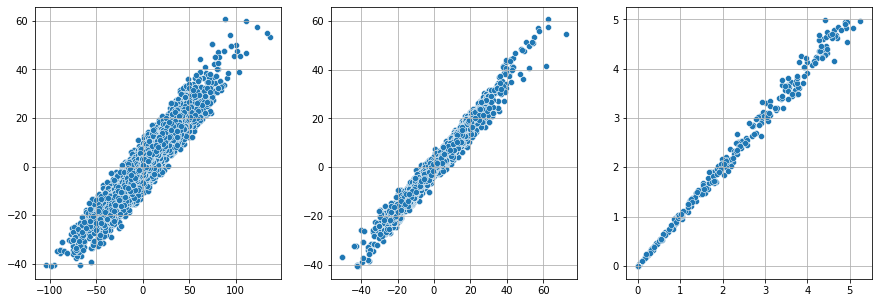

In [40]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['axes.grid'] = True

fig, axs = plt.subplots(1, 3)
sns.scatterplot(WW_pred, WW_gt, ax=axs.flat[0])
sns.scatterplot(LL_pred, LL_gt, ax=axs.flat[1])
sns.scatterplot(Phi_pred, Phi_gt_sq, ax=axs.flat[2])

In [41]:
# demonstrate speedup

In [ ]:
importlib.reload(model)
n_its = 500
device = 'cpu'
stable_start = time.time()
model.fit_model(y_dims,
                x_dims,
                all_datasets,
                d,
                y_concat,
                N,
                eps=1e-6,
                toprint=100,
                steps=n_its,
                method='stable',
                device=device)
stable_end = time.time()
print('Stable EM running on {} completed {} iterations in {} sec ({} its/sec)'.format(device, 
                                                                                      n_its,
                                                                                      stable_end - stable_start,
                                                                                      (stable_end - stable_start) / n_its))

standard_start = time.time()
model.fit_model(y_dims,
                x_dims,
                all_datasets,
                d,
                y_concat,
                N,
                eps=1e-6,
                toprint=100,
                steps=n_its,
                method='standard',
                device=device)
standard_end = time.time()
print('Standard EM running on {} completed {} iterations in {} sec ({} its/sec)'.format(device, 
                                                                                      n_its, 
                                                                                      standard_end - standard_start,
                                                                                      (standard_end - standard_start) / n_its))





0/500: (Wtprime-Wt)_F: 131.11292071547396 (Ltprime-Lt)_F: 89.2929692541109 (Phi_tprime-Phi_t)_F: 81.80431266131139


1.6366074766958825